In [1]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
     
# spacy for lemmatization
import spacy

In [2]:
import os
marks_sentences = []
for root, dirs, files in os.walk("text"):
    for file in files:
        if file.endswith(".txt"):
            print(os.path.join(root, file))
            with open(os.path.join(root, file), "r") as input:
                sentences = input.read().split(".")   #. denotes end of sentence
            marks_sentences.extend(sentences)
            
print(len(marks_sentences))
print(marks_sentences[10])

text/com.txt
424


The discovery of America, the rounding of the Cape, opened up fresh
ground for the rising bourgeoisie


In [3]:
marks_sentences

['\nThe history of all hitherto existing societies is the history of class struggles',
 '\n\nFreeman and slave, patrician and plebeian, lord and serf, guild-master\nand journeyman, in a word, oppressor and oppressed, stood in constant\nopposition to one another, carried on an uninterrupted, now hidden, now\nopen fight, a fight that each time ended, either in a revolutionary\nre-constitution of society at large, or in the common ruin of the\ncontending classes',
 '\n\nIn the earlier epochs of history, we find almost everywhere a\ncomplicated arrangement of society into various orders, a manifold\ngradation of social rank',
 ' In ancient Rome we have patricians, knights,\nplebeians, slaves; in the Middle Ages, feudal lords, vassals,\nguild-masters, journeymen, apprentices, serfs; in almost all of these\nclasses, again, subordinate gradations',
 '\n\nThe modern bourgeois society that has sprouted fcrom the ruins of feudal\nsociety has not done away with class antagonisms',
 ' It has but\n

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale 

In [5]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
     
# spacy for lemmatization
import spacy

In [6]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

marks_words = list(sent_to_words(marks_sentences))

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(marks_words, min_count=5, threshold=1) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[marks_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
for x in range(100):
    print(trigram_mod[bigram_mod[marks_words[x]]])

['the', 'history_of', 'all', 'hitherto', 'existing', 'societies', 'is', 'the', 'history_of', 'class', 'struggles']
['freeman', 'and', 'slave', 'patrician', 'and', 'plebeian', 'lord', 'and', 'serf', 'guild', 'master', 'and', 'journeyman', 'in', 'word', 'oppressor', 'and', 'oppressed', 'stood', 'in', 'constant', 'opposition', 'to', 'one', 'another', 'carried', 'on', 'an', 'uninterrupted', 'now', 'hidden', 'now', 'open', 'fight', 'fight', 'that', 'each', 'time', 'ended', 'either', 'in', 'revolutionary', 're', 'constitution', 'of_society', 'at', 'large', 'or', 'in_the', 'common', 'ruin', 'of_the', 'contending', 'classes']
['in_the', 'earlier', 'epochs', 'of', 'history', 'we', 'find', 'almost', 'everywhere', 'complicated', 'arrangement', 'of_society', 'into', 'various', 'orders', 'manifold', 'gradation', 'of', 'social', 'rank']
['in', 'ancient', 'rome', 'we', 'have', 'patricians', 'knights', 'plebeians', 'slaves', 'in_the', 'middle_ages', 'feudal', 'lords', 'vassals', 'guild', 'masters', 'j

In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove Stop Words
marks_words_nostops = remove_stopwords(marks_words)

# Form Bigrams
marks_words_bigrams = make_bigrams(marks_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
marks_lemmatized = lemmatization(marks_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(marks_lemmatized[:1])

[['history', 'hitherto', 'exist', 'society', 'history', 'class', 'struggle']]


In [11]:
# Create Dictionary
id2word = corpora.Dictionary(marks_lemmatized)

# Create Corpus
texts = marks_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1)]]


In [12]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('class', 1),
  ('exist', 1),
  ('history', 2),
  ('hitherto', 1),
  ('society', 1),
  ('struggle', 1)]]

In [13]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [14]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.043*"bourgeoisie" + 0.031*"revolution" + 0.029*"development" + '
  '0.018*"condition" + 0.016*"class" + 0.015*"feudal" + 0.015*"also" + '
  '0.014*"historical" + 0.014*"hand" + 0.014*"develop"'),
 (1,
  '0.037*"german" + 0.032*"way" + 0.026*"french" + 0.026*"world" + '
  '0.022*"literature" + 0.019*"socialism" + 0.019*"reformer" + '
  '0.018*"original" + 0.017*"philosophical" + 0.013*"half"'),
 (2,
  '0.027*"labour" + 0.025*"capital" + 0.024*"oppose" + 0.024*"existence" + '
  '0.021*"work" + 0.018*"condition" + 0.018*"attain" + 0.016*"class" + '
  '0.016*"union" + 0.015*"modern"'),
 (3,
  '0.065*"bourgeois" + 0.031*"take" + 0.019*"partly" + '
  '0.015*"social_condition" + 0.014*"worker" + 0.014*"compel" + 0.012*"master" '
  '+ 0.012*"little" + 0.012*"let" + 0.012*"antagonism"'),
 (4,
  '0.039*"movement" + 0.032*"exist" + 0.030*"therefore" + 0.029*"property" + '
  '0.026*"form" + 0.025*"production" + 0.022*"communist" + 0.018*"society" + '
  '0.017*"relation" + 0.015*"abolitio

In [15]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=marks_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.705797966873857

Coherence Score:  0.44890170759612624


In [16]:
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/Users/shawn/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/shawn/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/shawn/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/shawn/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/shawn/opt/anaconda3/lib/python3.9/

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.100412 -0.285142       1        1  17.531370
7     -0.226771 -0.047350       2        1  14.856302
0     -0.204906  0.036282       3        1  14.676137
3      0.065956  0.057011       4        1  10.833360
2     -0.066492 -0.040315       5        1   9.961475
8      0.044074  0.057874       6        1   7.870838
9      0.088559  0.008257       7        1   6.755445
6      0.045105  0.024147       8        1   6.729863
5      0.073645  0.103581       9        1   5.876663
1      0.080418  0.085657      10        1   4.908547, topic_info=             Term       Freq      Total Category  logprob  loglift
418     bourgeois  38.000000  38.000000  Default  30.0000  30.0000
506      movement  35.000000  35.000000  Default  29.0000  29.0000
73    proletariat  38.000000  38.000000  Default  28.0000  28.0000
67    bourgeoisie  70.000000  70.000000  Default  27.0000  27.0000
353       country  22.000000  22.000000  Default  26.0000  26.0000
...           ...        ...        ...      ...      ...      ...
1223    socialism   4.848682  18.266383  Topic10  -3.9382   1.6878
1351         true   1.936213   4.789652  Topic10  -4.8562   2.1085
23           time   3.111015  14.405218  Topic10  -4.3820   1.4816
919          idea   2.127219   9.354112  Topic10  -4.7621   1.5332
356      national   1.321605   6.051574  Topic10  -5.2381   1.4927

[433 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
927       1  0.919740      abolition
1047      9  0.539630        absence
170       3  0.877891       absolute
644       8  0.950926         accord
584       5  0.887464        acquire
...     ...       ...            ...
571       3  0.133350  working_class
146       3  0.129843          world
146      10  0.779055          world
1345     10  0.491454        writing
695       5  0.858057            yet

[475 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 8, 1, 4, 3, 9, 10, 7, 6, 2])

In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [18]:
mallet_path="/Users/shawn/Downloads/Mallet-202108/bin/mallet"

In [19]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=marks_lemmatized, 
                                                        start=2, limit=100, step=6)

Mallet LDA: 2 topics, 1 topic bits, 1 topic mask
Data loaded.
max tokens: 37
total tokens: 4514
<10> LL/token: -8.28317
<20> LL/token: -8.20113
<30> LL/token: -8.1567
<40> LL/token: -8.13755

0	25	bourgeoisie class proletariat form existence political labour development industry socialism movement condition modern interest character time revolutionary nation increase word 
1	25	society production bourgeois property social condition communist relation state country working_class long proletarian hand exist abolition german feudal idea man 

<50> LL/token: -8.13161
<60> LL/token: -8.13156
<70> LL/token: -8.12961
<80> LL/token: -8.14559
<90> LL/token: -8.1361

0	25	bourgeoisie class proletariat bourgeois condition form existence political labour development industry socialism movement modern interest character time revolutionary nation word 
1	25	society production property social communist country relation state working_class capital long proletarian hand exist abolition german feudal id

Mallet LDA: 8 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 37
total tokens: 4514
<10> LL/token: -8.71872
<20> LL/token: -8.54865
<30> LL/token: -8.50869
<40> LL/token: -8.44831

0	6.25	production relation capital long idea man word abolition change exchange society point section education woman produce rule trade child property_relation 
1	6.25	proletariat property socialism communist exploitation end literature class party communism proletarian vanish give acquire early true effect radical attain country 
2	6.25	bourgeoisie german feudal time french present power instrument nation lose law class antagonism abolish peasant bring world aristocracy individual ancient 
3	6.25	working_class interest bourgeois system industrial place family bourgeois_society political fight reactionary wage abolition worker require mere carry public aim agriculture 
4	6.25	class state character hand historical revolutionary increase work proletarian national freedom find productive_force ma


0	6.25	production condition existence relation socialism idea life mode change material exchange history rule produce population child aim reform people emancipation 
1	6.25	property form social development industry abolition order destroy early section education abolish trade disappearance worker small agriculture mere land ancient 
2	6.25	proletariat movement interest working_class proletarian man struggle product exist general party communism reactionary woman philosophical appropriation true criticism thing private_property 
3	6.25	communist country nation system french end common lose productive_force part call require bring exist union carry german present attain introduce 
4	6.25	class society state character hand capital revolution class_antagonism ruling_class law action antagonism element radical crisis fact face oppress half case 
5	6.25	bourgeois labour long feudal industrial labourer freedom free market national machinery place compel rise acquire competition make set per

Mallet LDA: 14 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 37
total tokens: 4514
<10> LL/token: -8.95368
<20> LL/token: -8.82662
<30> LL/token: -8.67214
<40> LL/token: -8.67831

0	3.57143	production common labourer movement competition exchange market commerce worker world generally true introduce independent necessarily attain side majority break eye 
1	3.57143	bourgeoisie fight reactionary productive_force wage peasant industry proletariat intend production individuality weapon science town advantage small precede question sweep philosopher 
2	3.57143	socialism character historical develop word freedom action create development future property_relation population division face effect oppress supply element ruin consist 
3	3.57143	form communist country proletariat literature communism education union political criticism oppose spring result low bourgeois_society social_condition revolutionise benefit community class_struggle 
4	3.57143	social bourgeoisie modern man

<420> LL/token: -8.57692
<430> LL/token: -8.55332
<440> LL/token: -8.57178

0	3.57143	working_class nation system end action population socialism base property_relation put political oppress good economic half truth exploitation early radical reproach 
1	3.57143	industry time product wage general education instrument true disappearance child small mere age cut century social_condition bind commerce belong phrase 
2	3.57143	bourgeois proletariat state modern exist common produce point mode philosophical power community case competition constantly period plan overthrow organise serve 
3	3.57143	communist country make socialist party woman rule compel element carry peasant exploitation competition necessarily write low power undeveloped desire petty 
4	3.57143	class political feudal word great freedom exchange reactionary fight productive_force history union aristocracy agriculture sway sweep monarchy absolute large selling 
5	3.57143	production property form destroy communism abolish acq

Mallet LDA: 20 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 37
total tokens: 4514
<10> LL/token: -9.09288
<20> LL/token: -8.87166
<30> LL/token: -8.81023
<40> LL/token: -8.79453

0	2.5	hand working_class state appropriation introduce universal philosophical oppose bourgeois side truth selling result create consist standpoint join threaten compel serve 
1	2.5	production individual mode labour early property_relation rule form child revolutionise work solely attack cost sell supply population machinery administrative function 
2	2.5	bourgeoisie political french revolutionary power world create produce disappear land people view country dissolution stand publication culture objection appropriating hour 
3	2.5	form idea order end fight radical attain put half position point future mere bind single petty_bourgeois conception reality matter fact 
4	2.5	freedom exchange find state woman crisis give trade rise exist class good religion traditional buy morality association wo

<210> LL/token: -8.66981
<220> LL/token: -8.70305
<230> LL/token: -8.76504
<240> LL/token: -8.73585

0	2.5	socialism national working_class create struggle world history hand early future thing truth kind directly critical utopian school vanishe buying battle 
1	2.5	production industrial ruling_class mode exchange generally rise result feudal_society contrary convert machinery grow navigation spring give writing circumstance equal nature 
2	2.5	bourgeoisie revolution general reactionary weapon fact time instrument communistic portion century correspond desire advanced join bring nobility requirement economist succumb 
3	2.5	communist french family action german practical radical social_condition supremacy power town philosophical represent separate price accompany publication preserve immigrate rent 
4	2.5	proletariat make section peasant capital require half effect communism worker large position mass general purely threaten low accord clear improvement 
5	2.5	exist country present re


0	2.5	feudal time struggle national literature world movement government education progress class_struggle character philosopher lead intervention competition local tear industrial development 
1	2.5	production exchange call aristocracy property_relation begin revolutionise trade undeveloped selling attain agriculture fall base foundation instrument gospel respect saint phrase 
2	2.5	bourgeoisie fight law manufacture early weapon face petty period absolute division antagonism break serve guild socialist majority enemy epidemic attainment 
3	2.5	socialism german french general interest great order philosophical true bring science represent fetter philistine reality human purely overcome separate air 
4	2.5	relation party social woman country point effect peasant free radical low hand single stand understand spring religion conservative partly hour 
5	2.5	country place abolish bourgeoisie instrument write civilisation openly grow directly constitute nationality base status mere critical

<880> LL/token: -8.66851
<890> LL/token: -8.65969

0	2.5	character national bourgeoisie place struggle ruling_class world vanish age manufacture necessarily begin owe philosopher cease front standpoint arise local convert 
1	2.5	production free exchange compel trade rise public property_relation labourer revolutionise phrase century force grow guild instrument single consciousness assure sink 
2	2.5	bourgeoisie social literature fight general peasant movement modern_industry monarchy stage labourer bind absolute emancipation selling concentration accumulate portion working_class supply 
3	2.5	socialism interest german french time practical criticism future aristocracy eye represent philistine utopian express rest desert miserable accord nay separate 
4	2.5	relation communist proletarian hand revolution family education instrument present generally openly navigation abolition civilisation sweep distinguish reduce parent misconception conscious 
5	2.5	country develop population part set 

Mallet LDA: 26 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 37
total tokens: 4514
<10> LL/token: -9.26543
<20> LL/token: -9.00942
<30> LL/token: -8.95591
<40> LL/token: -8.92408

0	1.92308	condition proletariat class generally character attain force production suffer fail publication accusation object reproach wife entire peasant material paint instinctive 
1	1.92308	man party point bring proletariat produce owe universal hand immense social_condition high dominate complete appropriating oppose rapidly piece country distinguish 
2	1.92308	society ruling_class aim independent oppress world create guild intervention overthrow conscious production element gospel category total impend impossible direct railway 
3	1.92308	form production hand mode destroy fact private_property acquire precede communistic home economic solely independence partly supply eye fast pedantry inventive 
4	1.92308	idea word product proletariat communism require find community master view rule rep

<160> LL/token: -8.84392
<170> LL/token: -8.82684
<180> LL/token: -8.89018
<190> LL/token: -8.81581

0	1.92308	develop working_class condition property_relation bourgeois intend benefit emancipation completely rapidly individual feature admit deprive revolt narrow kind commodity slave instil 
1	1.92308	proletariat political revolutionary general productive_force create sway write war representative support endeavour systematic degree asunder nature globe set monarchy advance 
2	1.92308	hand word product produce proletariat true measure break undeveloped reform expression appropriating low improvement direct critical attempt respect prostitution hateful 
3	1.92308	production industrial material mode world common disappear communistic previous population intellectual victory introduce death modern_industry german heart eternal urge spring 
4	1.92308	idea society history vanish create require plan dissolution real immense communication establish proposal point majority religious monarchy 

<620> LL/token: -8.80346
<630> LL/token: -8.86691
<640> LL/token: -8.8211

0	1.92308	communist working_class proletarian bourgeois lose supremacy party disappearance future write radical desire traditional exploit accord bind gospel circumstance admit finally 
1	1.92308	proletariat struggle great man rule ancient measure represent proclaim price middle_class requirement wive conscious progress overcome local patriarchal advance side 
2	1.92308	society peasant element private_property small bring agriculture oppose partly philosopher domain buying purely death constant saint consciousness expression complete dissolution 
3	1.92308	production exchange history word order effect rupture deprive advanced unfit fortify intellectual declare icaria duodecimo gradual bound bombastic sickly sentiment 
4	1.92308	develop common system woman compel thing introduce slave completely fall religion contest fast set grow phrase communism contact level attack 
5	1.92308	national reactionary literature na

Mallet LDA: 32 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 37
total tokens: 4514
<10> LL/token: -9.35234
<20> LL/token: -9.22288
<30> LL/token: -9.13561
<40> LL/token: -9.08595

0	1.5625	freedom country free union government property communism oppose communistic selling portion mode buy abolish life distinguish trade silly people deprive 
1	1.5625	compel increase give call character socialist proletarian work machinery division private_property dissolution owe religious domain community gain hour national wive 
2	1.5625	socialism labourer factory sway criticism organise suffice sink science directly support requirement follow replace hand purse yearning propaganda disintegrate misere 
3	1.5625	relation family common product working_class form produce proletarian land time respect threaten class_struggle skill piece conjure draw commerce reserve cropping 
4	1.5625	french live general ancient middle_class constitute person step pave rise function harmony completely ex

<160> LL/token: -8.98391
<170> LL/token: -9.0068
<180> LL/token: -8.99814
<190> LL/token: -8.98507

0	1.5625	development production exchange freedom free vanish fetter immense guild workman circumstance inroad communistic assure matter association motion cut attention straightaway 
1	1.5625	life socialist generally mere land modern_industry manufacture effect word degree constitute draw air reality dominate supremacy rest rural kind bind 
2	1.5625	socialism action criticism german future working_class forget conceal objection comprehend contest nation carry chiefly systematic category plan position woman proclaim 
3	1.5625	relation family private_property base middle_age ancient supremacy child long woman tear world society administrative significance total thing progress skill feature 
4	1.5625	society education class working_class undeveloped people seek offer member mass social_condition mode determine solely combination show search circulate tendency speculative 
5	1.5625	labour in

<670> LL/token: -8.95399
<680> LL/token: -8.95926
<690> LL/token: -8.93052

0	1.5625	abolition order real socialist seek partly factory instrument domain large support proposal oppose laborer theoretically miserable collision historical proclaim improvement 
1	1.5625	individual great power education struggle woman class_struggle contest production degree transform stage barbarian property sweep school purely association manufacturer machine 
2	1.5625	movement communist working_class aristocracy owe revolution effect front majority worker entire struggle philosopher heart war force disdain account habitually specially 
3	1.5625	exist disappearance child phrase culture offer belong total great distinctive chartist solely accumulate desert comprehend finally feel revolutionise differ failure 
4	1.5625	society common ruling_class set age effect appeal aim fast german feed assure distinguish blind experimental duodecimo definite undefined picture adequate 
5	1.5625	labour increase work prop

Mallet LDA: 38 topics, 6 topic bits, 111111 topic mask
Data loaded.
max tokens: 37
total tokens: 4514
<10> LL/token: -9.45256
<20> LL/token: -9.26852
<30> LL/token: -9.23743
<40> LL/token: -9.17923

0	1.31579	communist appropriation mode desire workman character create introduce part element belong thing intend produce material natural fresh great class_antagonism forcible 
1	1.31579	freedom woman section give reproach distinction proletarian understand recognise reform accumulate abolition unfit national veil switzerland endeavour affect danger cite 
2	1.31579	development idea exchange require feudal exist bourgeois_society eye individual antagonism convert christian consciousness rent due foundation century mere cracow critical 
3	1.31579	property abolish personal master majority reformer victory phrase charge admit intend fall intellectual home division specially cast cudgel singing pretend 
4	1.31579	society class mode bourgeoisie necessarily individuality eternal objection make fe


0	1.31579	communist party call aim reproach desire present introduce conceal buy labourer fresh impossible generally short regard enforcement spontaneous inventive describe 
1	1.31579	great reactionary section struggle general thing religion education critical raise victory complement accompany petty_bourgeois determine historical begin workshop feudal fanatical 
2	1.31579	feudal market produce property_relation feudal_society low ground advance preserve heart degree majority remain period disdain pedantry reconcile infancy philosophic signify 
3	1.31579	property capital case moment buying intend transform education hitherto school public admit urge conservative mode utopia purse bear caring excitement 
4	1.31579	society exist power intervention war existence bare reformer live general face social superstitious superintendence full exception speculative dose disperse applicable 
5	1.31579	german bourgeoisie fight lose movement government monarchy absolute political philistine immense 


0	1.31579	communist literature make appropriation disappearance intellectual domain owe proletarian completely culture unfit working_class create army chartist consistently babeuf enervate hide 
1	1.31579	bourgeoisie reactionary weapon fight history live single attainment christian uninterrupted instant reconcile length impartial typical pill liberal translation language disperse 
2	1.31579	abolition revolution education character public child disappear eye civilisation practical buying create community school complete artisan entire burst traditionally realisation 
3	1.31579	property form expression case transform reproach supply write land ruin support marriage cut dependent create squirearchy indistinct yield inventive prevail 
4	1.31579	class face condition progress directly philosophical strength rise silly petty_bourgeois consist express fall fast mediaeval accompany slave chartist bear critical 
5	1.31579	bourgeoisie aristocracy feudal monarchy absolute section exist idea bring

Mallet LDA: 44 topics, 6 topic bits, 111111 topic mask
Data loaded.
max tokens: 37
total tokens: 4514
<10> LL/token: -9.52631
<20> LL/token: -9.36189
<30> LL/token: -9.3395
<40> LL/token: -9.33859

0	1.13636	form labourer system small acquire modern factory require part struggle truth wage_labour long class realise bear danger speculative presuppose press 
1	1.13636	german lose form exist family relation guild chiefly requirement action supply power asunder religious find foment reserve picture propaganda hide 
2	1.13636	production long exchange find middle_age utopian peasant social wage_labour theoretically level manufacturer government feudal_society preference bird dub annex framework petty_bourgeois 
3	1.13636	bourgeoisie worker weapon community fight write introduce admit fall globe prison protective fanatic length sale sixteenth apology offspring witty arouse 
4	1.13636	philosophical division generally case bare previous advantage bring chartist marriage join rapidly concentrate

<130> LL/token: -9.17401
<140> LL/token: -9.18203

0	1.13636	form law material class_antagonism real battle benefit publication comprehend endeavour reform conception artisan class_struggle eye raw bind gradation stand originator 
1	1.13636	exist wage land truth expression system express victory element middle_age class disdain short reformiste standing chiefly monastic chief singing equable 
2	1.13636	production long exchange productive_force instrument fetter undeveloped original saint socialist describe grievance wonderfully dew squire earnest eighteenth hurl flesh properly 
3	1.13636	bourgeoisie working_class worker distinction movement reactionary strength directly traditional union property_relation representative immense push blind critical dose renew root tax 
4	1.13636	acquire peasant private_property petty ancient case country middle_class intend masse material bourgeoisie miraculous organiser enervate wrap finish liberal ultimately disastrous 
5	1.13636	society socialist soc

<420> LL/token: -9.23466
<430> LL/token: -9.2159
<440> LL/token: -9.21379

0	1.13636	time hand fantastic attain contest nature serve exist attainment requirement true reality overcome patriarchal reformiste situation crude depreciate sale intoxicate 
1	1.13636	make country proletariat education union communist worker intervention progress immediately petty_bourgeois consciousness raise improvement period monarchy feudal_society regard inculcated wonderfully 
2	1.13636	proletarian common character power distinction proletariat ruling_class collision modern saint measure christianity extensive contrary pave respect economic total reality officially 
3	1.13636	nation exploitation end put communist wage_labour base future manufacturer support misconception minority previous small question violently dream bear adequate organiser 
4	1.13636	society history government religion personal seek law show direct economist accusation objection level price reactionist disdain pedantry differ esprit d

<840> LL/token: -9.20777

0	1.13636	make exist industrial communism factory competition army chartist suffer saint charge spring constantly labour care robe fantasy overlooker hurl irreverent 
1	1.13636	labour appropriation bourgeois_society division master accord movement work lead proposal fruit century distinguish democratic sect gradual legislation flesh spirit prophecy 
2	1.13636	hand state vanish cease reproach suffice write fortify rapidly religious land side straightaway ally experimental comfortable tendency hide emasculate dub 
3	1.13636	proletarian communist education direct intervention culture advanced chiefly inventor dose blue ear progressive contradiction conception reason contrast invent spring rot 
4	1.13636	revolution commerce lose give radical immense navigation oppose support extensive science generally unbelief fouri babeuf redress skin alienation nonsense signify 
5	1.13636	abolition union reform require understand administrative nationality oppose feed workman c

Mallet LDA: 50 topics, 6 topic bits, 111111 topic mask
Data loaded.
max tokens: 37
total tokens: 4514
<10> LL/token: -9.67104
<20> LL/token: -9.47507
<30> LL/token: -9.45266
<40> LL/token: -9.38301

0	1	state private_property agriculture constantly land subsistence person association war modern fall realisation proclamation inculcated administrative bird poor catholic ear bank 
1	1	man material word place universal radical communism cost separate real serve complete deep clear show naked give unbelief pedantry standing 
2	1	freedom ruling_class competition reality buying buy combination attempt domain partly sex conjure call constitution declare yearning caring founder cast supplementary 
3	1	industry struggle labourer child commerce question front school burst grow european cite category philosophic beetroot barter apple graduate contradiction seduce 
4	1	compel force hand generally great bourgeois sweep write attain wive status disciple describe confront manuscript heathendom eightee


0	1	communism life ground phrase cut free find accusation bare violent finally miserable independent increase cracow purse dream sixteenth crop eagerly 
1	1	word man compel age common religion ruling_class saint nay narrow advance great brutally bombastic steep kill writer moral modify prostitute 
2	1	form disappear child truth eternal sell nature individual modern_industry low skill cost weapon universal bring mode capital market instant squirearchy 
3	1	hand condition point lose property_relation fail good socialist traditional manufacture rise proletariat pedantry realisation deaden inverse flogging signify cudgel waste 
4	1	history productive_force find law forget point bourgeois buying workshop chain consistently proclamation picture lessen prevention prussian cramp acuteness strike philosophy 
5	1	create element period fact dissolution independent effect independence express continually sink lose national condition undefined reconstruction experiment spontaneous contrive voice 


<610> LL/token: -9.29698
<620> LL/token: -9.32255
<630> LL/token: -9.31994
<640> LL/token: -9.28745

0	1	bourgeoisie competition rule sink stage buy complete unfit disdain blind kill shopman renew ludicrous outstrip succumb people lot clap buying 
1	1	bourgeoisie radical private_property benefit overthrow enemy contest constantly tenth intend front matter period establish open circulate interpretation professor seize aristocrat 
2	1	character national intervention victory arise admit workman constantly declare immediately preference owen adequate finish attainment legislation easy potato ordinary love 
3	1	social population eye practical call base masse sell epidemic literature lampoon action separate insurrection realise spontaneous true pure eagerly apology 
4	1	great revolution force bourgeoisie chiefly necessarily workman daily contrive length embroider bone stubborn crying traffic credit follow pace emancipation speak 
5	1	production law history original significance proposal thin

Mallet LDA: 56 topics, 6 topic bits, 111111 topic mask
Data loaded.
max tokens: 37
total tokens: 4514
<10> LL/token: -9.7201
<20> LL/token: -9.56462
<30> LL/token: -9.50732
<40> LL/token: -9.50441

0	0.89286	bring freedom give benefit wage_labour land navigation great plan culture expression oppose previous class_struggle manufacturer rural insurrection purse failure babeuf 
1	0.89286	capital long family material effect join aim time cropping contrive length meanness eagerly inequality apple whispering bank emancipation parent monopolised 
2	0.89286	competition market commerce world generally civilisation measure wage religious pave vanish bourgeoisie attention philosophic harmony cudgel liberty hallow fighting fluctuate 
3	0.89286	mere moment impossible time fortify centralisation element condition slave agreement traditionally propose sweet fit blue destine distribution examination objection contrast 
4	0.89286	existence condition history crisis personal reform intend appeal low prod

<140> LL/token: -9.41268

0	0.89286	industrial place agriculture peasant proclaim measure unfit artisan endeavour situation administrative nonsense deception overproduction precursor phrase irreverent strike prophecy sight 
1	0.89286	capital long live exchange transform intend overcome vanish reconcile adequate pill pressure high arouse distribution plan rupture monopolised person complete 
2	0.89286	competition political stage offer battle due epidemic dependent industry full professor preach socialist pick drop loud ludicrous oblige reform trap 
3	0.89286	bourgeois immense develop single economist forget effect rest majority brutal naked vanish differ disciple paint babeuf model approach exhibit vast 
4	0.89286	condition existence reform emancipation follow centralisation valuable eagerly cramp democracy chorus slavish shopkeeper break decade extinction sidedness conduct vigour mere 
5	0.89286	bourgeois commodity epoch base wife finally piece remain vanish push originator superintend

<590> LL/token: -9.44803

0	0.89286	relation material change instrument idea demand rule skill intellectual raw home real superstitious propaganda sight idleness vanishe rent consequent involuntary 
1	0.89286	interest communist aristocracy government supply threaten philosopher desert acquire short support pedantic belong pure fully drop revenge indictment philosophy action 
2	0.89286	state good element position partly people recognise preserve feed proletarian centralisation uninterrupted end chain pedantry skin robe monk sight absolutely 
3	0.89286	modern form fact part abolition precede write attack common squirearchy justification definite spontaneous stubborn fit disperse aspire incisive upstart purpose 
4	0.89286	existence condition hand economic wage_labour attempt saint nature contrary insurrection philosophy pretend widen reproduce term actual shape augmentation continue centralise 
5	0.89286	place private_property solely break nation administrative lampoon circumstance propos

Mallet LDA: 62 topics, 6 topic bits, 111111 topic mask
Data loaded.
max tokens: 37
total tokens: 4514
<10> LL/token: -9.80182
<20> LL/token: -9.6035
<30> LL/token: -9.60017
<40> LL/token: -9.54572

0	0.80645	element present free commerce partly question level lose government gradation feeling prevail sugar indirect purely favour abolition civil antagonistic collision 
1	0.80645	interest german wage_labour working_class government benefit revolution find undeveloped fail saint true tear independent agreement yield length commercially stoop spirit 
2	0.80645	destroy form state political establish class_antagonism make point epoch support bear conversion squire professor pedantic language deception parson heart inheritance 
3	0.80645	abolish state labour aristocracy machinery reform degree draw real systematic sink concentrate word situation desirous golden drop follow position hallow 
4	0.80645	socialist private_property make exist movement victory competition distinctive true fruit crea

<160> LL/token: -9.49767
<170> LL/token: -9.57586
<180> LL/token: -9.55964
<190> LL/token: -9.53024

0	0.80645	industrial child rest guild fight finally piece army commodity rise society sect harmony petty_bourgeois mother distribution credit christian disgusting guilty 
1	0.80645	interest law socialist government preserve offer truth majority enemy cost stage reduce independent feature support enforcement conversion steep stubborn fit 
2	0.80645	capital hand proletariat productive_force communism good appropriation tenth small entire switzerland sickly prussian strike formulate distribution legalise replace join improve 
3	0.80645	development market action character personal moment direct death emancipation set duodecimo peaceful levelling depreciate barter throe confess rightly final front 
4	0.80645	condition communist low political thing significance desert party lose struggle pedantry miraculous seize shopman stoop high echo conscience trap assume 
5	0.80645	existence condition bo


0	0.80645	historical abolish compel force bourgeois_society feudal_society slave contest raw death nation sect inverse contrive initiative undeveloped annexation juridical naturally share 
1	0.80645	interest movement represent fight working_class publication belong make increase enforcement imaginable bone misty high lot reproduction express line front sectarian 
2	0.80645	bourgeoisie revolution eye mere expression level working_class railway capital unbelief fanatical bombastic pure charity potato falutin exhibit incapacity criticism school 
3	0.80645	bourgeoisie appeal portion period carry writing comprehend directly squirearchy duodecimo yield fanatic fully mother apple destine socialism eternal loss human 
4	0.80645	rise personal social working_class agriculture replace question patriarchal tremble belief found undeveloped cite speculative mountebank intoxicate fit legitimist domain apply 
5	0.80645	existence condition religion industry agreement humanitarian exception fantasy ind

Mallet LDA: 68 topics, 7 topic bits, 1111111 topic mask
Data loaded.
max tokens: 37
total tokens: 4514
<10> LL/token: -9.92595
<20> LL/token: -9.76252
<30> LL/token: -9.65565
<40> LL/token: -9.70004

0	0.73529	law revolution write formation middle_class reproach aim class isolated reconcile definite instinctive exception sentiment sweet annex forbid bit allege favour 
1	0.73529	idea require ruling_class ancient traditional consciousness oppose gain dethronement positive vocation distribution transport democracy school intervention share act identical prolong 
2	0.73529	abolition system town power worker call deprive distinction freedom ally cite foul nonsense burning plan reality private meaning beget enlightenment 
3	0.73529	socialist industrial spring disappear national class_antagonism degree supremacy write eternal matter form duodecimo consistently fantastic emasculate atmosphere asceticism thenceforth circumstance 
4	0.73529	proletariat general effect future bourgeois_society rui

<130> LL/token: -9.62323
<140> LL/token: -9.64007

0	0.73529	character hand christianity suffice switzerland reserve experimental owen voice prison scarecrow original renew petty_bourgeois asceticism drop prophecy properly unavoidable consist 
1	0.73529	social order fresh barbarian care sect sweet intermediate echo indirect jurisprudence personally ultimate continue centralise restore impossible venerable middle_class corporate 
2	0.73529	production relation communism abolition acquire general system morality question wage place contradiction people involve accord organise restrict cost periodical compatible 
3	0.73529	bourgeoisie true half aristocracy present proletarian push lampoon measure result rural deaden professor earnest pine tree indictment basis living member 
4	0.73529	vanish monarchy absolute develop general undeveloped minority trace war wage state disintegrate dose presuppose commercially ordinary bag credit inheritance stop 
5	0.73529	socialist petty phrase intervention

<440> LL/token: -9.58107

0	0.73529	working_class section create condition oppose attain civilised chain blind superstitious fanatical category supplementary pine sugar phrase barter laughter witty pretty 
1	0.73529	bourgeoisie modern weapon oppress reduce ground found chiefly cast comfortable solemnly asceticism heart echo disgusting identical buying shape highway gradually 
2	0.73529	production instrument form property_relation stage owe harmony accumulate combination caring wrap core waste soil eternal wrangle enrich reformer foreign advantage 
3	0.73529	free trade arise period appeal productive_force representative distinctive redress grievance poor rally degree throe conceal communistic undoubtedly lay view range 
4	0.73529	product world plan progress result convert modern determine proletarian separate modern_industry condition agreement definite reconstruction founder cobwebs substitution public proposal 
5	0.73529	character ruling_class law disappear carry education fetter gene

<890> LL/token: -9.57585

0	0.73529	bring eye action proletarian establish advanced fruit factory burst reconcile pedantic love christian naturally trap practical person spring obliterate level 
1	0.73529	aristocracy instrument exist school factory administrative immigrate deprive education distinction entire feature cracow ally emasculate pick plead resort express fall 
2	0.73529	present instrument desire rise total finally immediately disintegrate circulate belong seize intermediate echo lampoon ridiculous indignation beget conclusion supremacy small 
3	0.73529	condition communism constitute private sweep communist future agriculture rise superstitious caring levelling german fit sight soil proposal flare apply widen 
4	0.73529	labourer place wage develop history bare distinction local habitually humanitarian sixteenth crop conscience influence expression yoke overthrow scum back tradesman 
5	0.73529	feudal work monarchy fetter absolute sex stage intellectual squirearchy valuable mea

Mallet LDA: 74 topics, 7 topic bits, 1111111 topic mask
Data loaded.
max tokens: 37
total tokens: 4514
<10> LL/token: -9.93664
<20> LL/token: -9.85345
<30> LL/token: -9.71954
<40> LL/token: -9.73887

0	0.67568	labour machinery carry bring workshop commodity agreement function immigrate apple actual sex meal expose sorcer subjection application halo set natural 
1	0.67568	historical religion conservative distinction civilisation require world establish publication transcendental sickly bone pill squire attainment original immigrate traffic incapacity radical 
2	0.67568	state practical mere buying force harmony reactionary forcible pedantic misery parson coat distribution requisite appropriating morality association begin age tariff 
3	0.67568	exploitation order form write state nay part exist accumulate communism join religious disciple contrive describe schoolboy instance aspire equable examination 
4	0.67568	development work correspond individuality government brutal general step acco

<190> LL/token: -9.70751

0	0.67568	member low universal desert subsistence degree brutal state reconstruction humanitarian animal speculative reverse positive petty_bourgeois forget singing plan insufficient hallowed 
1	0.67568	development life oppose immense production distinguish cracow speech adequate schoolboy purpose economically position private forbid ride trace anythe bribe involve 
2	0.67568	communist fantastic exchange supremacy category silly comprehend aim exploitation generally squirearchy enforcement care reformiste fanatical valuable kill fashion misty alienation 
3	0.67568	labour small proletarian mode bourgeoisie division ground abolish factory middle_age grievance hide potato feudalist move school lament earn appropriation back 
4	0.67568	bourgeois make people dissolution fail dominate feed attention picture instinctive yield spread framework irreverent contradiction act communism term slavish impend 
5	0.67568	proportion increase labourer sweep advance epidemic cent

<570> LL/token: -9.65552
<580> LL/token: -9.69558
<590> LL/token: -9.73635

0	0.67568	social abolition objection comprehend owe found immigrate crying stop sheer groundwork sentence nationality incompetent number operative organise masse exact wealth 
1	0.67568	law public intend rupture principle theoretically government correspond forcible animal nonsense heathendom petty_bourgeois consecrate conception selfish living replace antagonism civil 
2	0.67568	proletariat common nation struggle proletarian independence overthrow social_condition insurrection foment speech notion vanishe undoubtedly bare independently front threaten altogether method 
3	0.67568	labour child appropriation navigation critical abolish burst price personal modern_industry gradual figure danger annexation mother charity ordinary requisite average oppose 
4	0.67568	bourgeoisie worker union attain desire individual endeavour christian determine aim break instant traditionally duty instance dethronement misery povert

Mallet LDA: 80 topics, 7 topic bits, 1111111 topic mask
Data loaded.
max tokens: 37
total tokens: 4514
<10> LL/token: -10.00859
<20> LL/token: -9.89409
<30> LL/token: -9.87385
<40> LL/token: -9.75032

0	0.625	class society communist early switzerland fit blue potato people community rent resort sum digger furnish rapidly compact mass revolt rescue 
1	0.625	exist abolish make reproach desire communist due write inventor duty necessitate private idleness theory centralise hateful exact destructive dependence hand 
2	0.625	state result school thing working_class sway serve reconcile silly ultimately overproduction hypocritical cudgel truth forbid idea threaten party historical destructive 
3	0.625	introduce communist domain previous christian buying collision status openly guild short propose earnest disastrous commercially easy oblige tax confess rest 
4	0.625	present aim individuality communist culture traditional objection independence set conversion finish cramp aspire despotic traini

<130> LL/token: -9.76792
<140> LL/token: -9.7715

0	0.625	social socialist serve rapidly motion develop found edition crude bound steep inequality hindquarter consist daughter educate quantum expression complete communist 
1	0.625	advantage philosopher industrial industry saint writing interest place circulate overproduction concentration amount throe induce average absolutely bit independence fall wife 
2	0.625	capital worker party union wage market make economist private_property naked caring societie imaginable spread overlooker independently exclusively substance conscious hold 
3	0.625	working_class long section action draw raw refer wrap rising hallowed completely wrangle theory practically nationality range enlightenment distinction maintenance manufacturing 
4	0.625	free condition selling association buying rule bourgeois trade embroider dew mountebank love chief sinister move emancipation content culture wife rot 
5	0.625	exploitation socialism state capital attempt precede eu

<590> LL/token: -9.74616

0	0.625	produce develop lose accusation tenth private_property feudal_society justification caring cobwebs innocence annex writing pressure approach pine tree ordinary golden coat 
1	0.625	free capital exploitation eternal advanced religious establish purse excitement interpretation clerical tax follow undoubtedly change due miserable active proclaim openly 
2	0.625	production require ruling_class peasant supremacy feeling inventor original sight progressive front shape finally number locality retire restrict race sell comprise 
3	0.625	product mode appropriating form sink violently blind owen inequality bond anarchy bitter laborer yoke continue decay masse destructive endanger local 
4	0.625	state national country marriage production comfortable disintegrate schoolboy monastic tinge trader impose pauperism altogether result rule intellectual universal kind exodus 
5	0.625	selling serve condition wage_labour revolutionise domain future motion owe home religiou

Mallet LDA: 86 topics, 7 topic bits, 1111111 topic mask
Data loaded.
max tokens: 37
total tokens: 4514
<10> LL/token: -10.12992
<20> LL/token: -9.98207
<30> LL/token: -9.98145
<40> LL/token: -9.86579

0	0.5814	national personal condition sympathy rebel degree absence actual discover abolish enlightenment supply adapt numerous universal consumption aqueduct bring mere numberless 
1	0.5814	industrial carry necessarily character belief feeling cropping conversion doom voice conceive sentiment robe follow philosophy people hallowed sum enlightenment late 
2	0.5814	modern manufacture truth revolution preserve silly communism advanced wife progress collision enemy improvement oppress attention insist fanatical inverse hide speculative 
3	0.5814	state monarchy absolute accompany great wive country squirearchy wrap embroider sixteenth preach wr modify examination alter theory decisive rapidly sink 
4	0.5814	bourgeoisie sweep industry french admit worker sink make complement generally isolated 

<130> LL/token: -9.93855
<140> LL/token: -9.84569

0	0.5814	class_antagonism disappearance ancient culture element victory solely expression religion epoch imaginable esprit bitter waste degree variety consist constitute proposal selfish 
1	0.5814	industrial place army brutal form ultimately inequality branch heart possibly indirect desire absolutism abolish worker historical officer command cost endanger 
2	0.5814	state exist child modern philosophical workshop history doom inculcated ludicrous equable follow total loss lament undoubtedly thing violent wealth devastation 
3	0.5814	feudal monarchy absolute enemy nobility harmony cash dream humanity explode contradiction naturally public precisely final communism security theoretically precipitate education 
4	0.5814	exploitation bourgeoisie direct bourgeois_society seek exploit habitually search sixteenth aspire hurl vegetate preach loud liberty seduce alter training communistic living 
5	0.5814	change reform world rent reformer idea c

<530> LL/token: -9.84768
<540> LL/token: -9.86477

0	0.5814	man find order sway early instil paint embroider dew offer proposal contrast independence desire deep desert active disposal economical continent 
1	0.5814	exploitation crisis kind serve period independent icaria dose sight reality intend favour threaten involve swamp burden wealth settle sense profane 
2	0.5814	society education social_condition intervention position tremble excitement misere pressure chief coat christian pace absolutism depict union smash capitalist arise individual 
3	0.5814	bourgeois_society critical power barbarian consist acquire burst put directly length crop offspring bank truth vanishe intend reactionary back artisan fluctuate 
4	0.5814	revolution sweep hand writing theoretically partly declare inventor hide traffic coercive pace wrangle person surplus requisite yoke matter rot recognition 
5	0.5814	child association due wive supremacy reactionary extensive country class concern robe golden equable re

Mallet LDA: 92 topics, 7 topic bits, 1111111 topic mask
Data loaded.
max tokens: 37
total tokens: 4514
<10> LL/token: -10.12405
<20> LL/token: -10.02721
<30> LL/token: -9.99985
<40> LL/token: -10.0186

0	0.54348	interest movement word aristocracy coat solely allege continue back organisation lump connect character expand uninterrupted 
1	0.54348	relation literature member wife call proletariat proletarian vanish describe wonderfully seize sinister educate communism abolition tool fluctuate scale age officer 
2	0.54348	development set suffice dream failure dethronement burning indictment transport complete exclusively result stage manufacturing extinction property character fact commerce colony 
3	0.54348	power disappear transform personal money moment law national kind inverse acuteness intermediate stoop loss selling hard sentence isolation augmentation veiled 
4	0.54348	property practical plan intend member destroy account function harmony declaim substitution collective shape artisa

<190> LL/token: -9.9199

0	0.54348	interest government aristocracy phrase eye succumb sway tree formulate owner advanced fruit feel attain exertion middle_age master 
1	0.54348	union philistine transform matter class_struggle critical figure extreme originate petty_bourgeois potato vast democracy pauper process future article disposal gigantic compel 
2	0.54348	society forget great proposal distinction organise barbarian insurrection writing crying pretty absence laziness allege communism spring aristocracy masse mass similar 
3	0.54348	national struggle class precede phalanstere impartial socialistic horrify wheel violent begin improvement numerous display word play state modern_industry plebeian rank 
4	0.54348	property form property_relation seize german flesh love reality bit present centralise factory restrict extensive century crusade sway trade impulse 
5	0.54348	fight reactionary weapon middle_class necessarily utopian admit wage labourer traditionally spontaneous golden lampoo

<640> LL/token: -9.95672

0	0.54348	find worker political revolutionise formation contrary relation attainment emasculate spirit feudalist progressive christian altogether advantage battle hierarchy conquest chemistry concentrate 
1	0.54348	proletariat solely product admit idea point found wonderfully nonsense truth conception officially school tautology desire sum discover involuntary wage_labour augmentation 
2	0.54348	disappearance critical collision exploitation manufacture act desire replace nature bourgeois labour ally reconcile decompose steep hurl industrially supremacy promoter violent 
3	0.54348	bourgeois individual condition sense attention wrap economist renew flesh waste ridiculous confess small slumber call great revolutionary 
4	0.54348	political market determine moment antagonistic remain slave search concern concentration buying nationality exclusively feed drag centralise organise factory conquest power 
5	0.54348	hand eternal proletarian revolution great adequate ana

Mallet LDA: 98 topics, 7 topic bits, 1111111 topic mask
Data loaded.
max tokens: 37
total tokens: 4514
<10> LL/token: -10.26141
<20> LL/token: -10.14143
<30> LL/token: -10.06596
<40> LL/token: -10.05374

0	0.5102	bourgeoisie working_class put sell founder decompose grievance bombastic manuscript loud sight insufficient uniformity thereto lead radical nationality fall hold aristocracy 
1	0.5102	society call buying duodecimo situation affect pedantic spectacle singing plan vanishe member involuntary impend fluctuate spell nature bourgeois dependence clime 
2	0.5102	man ground society reproach wage_labour piece recognise cobwebs lamentation follow solely average bit morality threaten ware smash exploit recruit worthless 
3	0.5102	labour education science immediately degree property_relation character impartial brutally steep sentiment finish constitute public horrify conclusion deeply combination manual aim 
4	0.5102	socialist correspond french accusation portion railway deaden petty_bour

<180> LL/token: -10.07196
<190> LL/token: -10.06338

0	0.5102	small generally measure action gospel effect wage realisation innocence blue shopman succumb legalise proposal eternal membership abolish throw rot precipitate 
1	0.5102	lose absolute assure intellectual gradual embroider pill positive vegetate phrase progressive disgusting radical allege theoretical rest incompetent majority lurk disappear 
2	0.5102	class establish bourgeois_society publication enemy suffice history ruling_class appeal acquire experimental properly emancipation ridiculous jurisprudence contact swamp agriculture chinese home 
3	0.5102	condition end administrative sell sway propaganda typical wrap schoolboy confiscation ideological cease member forward altogether status proletarian disposal manufacturing individual 
4	0.5102	constitute public form adequate exception sickly monk tinge win variety contradiction absence import age hateful manufacturer capitalist hatred sense profane 
5	0.5102	independent point p

<620> LL/token: -9.97113
<630> LL/token: -10.03551
<640> LL/token: -10.01733

0	0.5102	practical generally position national socialism rupture show time tremble blind gospel organiser flogging lamentation core literary school deep point appeal 
1	0.5102	bourgeois individual civilisation european realise deaden lessen finish esprit eagerly consecrate coat soil rationalist hear idleness ago historical portion aim 
2	0.5102	character require capital miserable struggle pedantry undeveloped refer contempt mortification flesh pawnbroker embitter destructive steam generation taxation tariff satisfied establishment 
3	0.5102	property personal form supremacy appropriation fanatical affect robe good misery oblige effect total human nationality incompetent artisan precipitate occasional result 
4	0.5102	antagonism degree individuality section require veil feudal societie parson forget revenge prophecy literary measure multiplicity contradiction thereto thing transform sentence 
5	0.5102	communist

In [20]:
len(coherence_values)

17

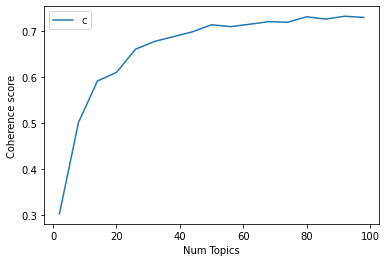

In [21]:
# Show graph
limit=100; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [22]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.302
Num Topics = 8  has Coherence Value of 0.5008
Num Topics = 14  has Coherence Value of 0.5916
Num Topics = 20  has Coherence Value of 0.61
Num Topics = 26  has Coherence Value of 0.6607
Num Topics = 32  has Coherence Value of 0.6775
Num Topics = 38  has Coherence Value of 0.688
Num Topics = 44  has Coherence Value of 0.6986
Num Topics = 50  has Coherence Value of 0.7138
Num Topics = 56  has Coherence Value of 0.7098
Num Topics = 62  has Coherence Value of 0.715
Num Topics = 68  has Coherence Value of 0.7206
Num Topics = 74  has Coherence Value of 0.7194
Num Topics = 80  has Coherence Value of 0.7312
Num Topics = 86  has Coherence Value of 0.7262
Num Topics = 92  has Coherence Value of 0.7324
Num Topics = 98  has Coherence Value of 0.7298


In [23]:
# Select the model and print the topics
optimal_model = model_list[10]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(21,
  '0.139*"free" + 0.076*"freedom" + 0.063*"aim" + 0.063*"trade" + '
  '0.051*"previous" + 0.051*"moment" + 0.038*"subsistence" + '
  '0.038*"individuality" + 0.025*"real" + 0.025*"traditional"'),
 (8,
  '0.273*"proletarian" + 0.091*"exploitation" + 0.076*"party" + '
  '0.076*"distinction" + 0.061*"master" + 0.045*"association" + '
  '0.030*"class_antagonism" + 0.030*"offer" + 0.015*"tradesman" + '
  '0.015*"handicraftsmen"'),
 (48,
  '0.089*"present" + 0.063*"necessarily" + 0.051*"union" + 0.051*"historical" '
  '+ 0.038*"complement" + 0.038*"destroy" + 0.038*"world" + 0.025*"violent" + '
  '0.025*"uninterrupted" + 0.025*"future"'),
 (20,
  '0.507*"bourgeoisie" + 0.055*"immense" + 0.041*"single" + 0.014*"uniformity" '
  '+ 0.014*"corner" + 0.014*"hand" + 0.014*"lay" + 0.014*"evident" + '
  '0.014*"cost" + 0.014*"knack"'),
 (45,
  '0.108*"education" + 0.062*"instrument" + 0.046*"time" + 0.031*"exploit" + '
  '0.031*"religious" + 0.031*"harmony" + 0.031*"suffer" + 0.031*"replace" +

In [24]:
import pandas as pd

In [25]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=marks_sentences):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=marks_sentences)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

/var/folders/tq/jmjsbxxn7f9_q8hh0yz05_dm0000gn/T/ipykernel_15553/4132142342.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/tq/jmjsbxxn7f9_q8hh0yz05_dm0000gn/T/ipykernel_15553/4132142342.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,11,0.0843,"struggle, history, modern, form, antagonism, w...",\nThe history of all hitherto existing societi...
1,1,44,0.0520,"common, battle, long, constant, finally, sprin...","\n\nFreeman and slave, patrician and plebeian,..."
2,2,11,0.0435,"struggle, history, modern, form, antagonism, w...","\n\nIn the earlier epochs of history, we find ..."
3,3,56,0.0678,"call, grow, total, formation, belong, mere, pa...","In ancient Rome we have patricians, knights,\..."
4,4,25,0.0288,"increase, labour, work, proportion, machinery,...",\n\nThe modern bourgeois society that has spro...
5,5,11,0.0512,"struggle, history, modern, form, antagonism, w...","It has but\nestablished new classes, new cond..."
6,6,47,0.0268,"proletariat, develop, revolution, civilisation...","Our epoch, the epoch of the\nbourgeoisie, pos..."
7,7,37,0.0478,"proletariat, great, rule, result, require, com...",Society as a whole is more and more\nsplittin...
8,8,23,0.0335,"early, time, half, benefit, eternal, feudal_so...",\n\nFrom the serfs of the Middle Ages sprang t...
9,9,31,0.0314,"element, stage, private_property, manufacture,...",From these burgesses the first elements of th...


In [26]:
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0,0.0561,"exist, class, production, true, modern, revolu...",Only from the point of view of being the most...
1,1,0.0943,"movement, interest, government, working_class,...","\nIndependent, or but loosely connected provin..."
2,2,0.1407,"general, criticism, public, french, write, sel...","This talk about free selling and buying, and ..."
3,3,0.0897,"life, population, part, base, reactionary, rel...","It\nhas created enormous cities, has greatly ..."
4,4,0.0646,"revolutionary, destroy, practical, eye, seek, ...","\n\nA second and more practical, but less syst..."


In [27]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,11,"struggle, history, modern, form, antagonism, w...",11.0,0.0259
1,44,"common, battle, long, constant, finally, sprin...",11.0,0.0259
2,11,"struggle, history, modern, form, antagonism, w...",6.0,0.0142
3,56,"call, grow, total, formation, belong, mere, pa...",7.0,0.0165
4,25,"increase, labour, work, proportion, machinery,...",4.0,0.0094
...,...,...,...,...
419,36,"bourgeois, production, side, century, truth, c...",NaN,NaN
420,47,"proletariat, develop, revolution, civilisation...",NaN,NaN
421,8,"proletarian, exploitation, party, distinction,...",NaN,NaN
422,48,"present, necessarily, union, historical, compl...",NaN,NaN
